# __RNN NLP Disaster Tweets Kaggle Project__

## The Problem

The Purpose of this project is to create an algorithm capable of classifying whether or not a "tweet" is referring to the occurrance of an actual, real life disaster or not, utilizing Recurrent Neural Networks via tensorflow. This could be potentially very useful for noticing and recognizing disasters via the accounts firsthand witnesses through social media platforms such as twitter.

Below are the libraries that I used

In [251]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Dense,Bidirectional
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cell below checks

In [252]:
# Check to ensure that GPU acceleration is working properly
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## __The Data__

The training data available this problem is a table containing information for 7613 tweets. Each row contains an entry pertaining to: 
- "id", the unique tweet ID
- "keyword", a keyword from that tweet (if applicable)
- "location", the location of that tweet (if applicable)
- "text", the text contained within that tweet 
- "target", whether or not that tweet is classified as referencing a disaster (1) or not (0)

The test data provided has the same for 3263 tweets, except for "target" 

In [253]:
data_dir = "A:/RNN_project/dataset/"
train_file = data_dir + "train.csv"
test_file = data_dir + "test.csv"

test = pd.read_csv(test_file)
train = pd.read_csv(train_file)

In [254]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [255]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## __Exploratory Data Analysis and Feature Engineering__

The EDA for this project focuses on figuring out some features and distributions that could help when choosing certain hyperparameters for the model. 

This section also focuses on removing/modifying particular features that could become noise to the model, this includes:

-The randomized strings within URLs
-special characters, like punctuation (excluding # and @)
-letter cases
-stopwords

Some further feature engineering is also employed, where keywords are injected into the tweets in the form of hashtags.

### __Distribution of counts__

To start, let's look at the counts of the data

In [256]:
counts = train["target"].value_counts()
print(counts)

0    4342
1    3271
Name: target, dtype: int64


These values are reasonable. If the difference between the two were too high, it may become difficult for our model to distinguish between things, and downsampling may have been necessary. However, this discrepency should be fine. Let's look a bit more into it.

Text(0.5, 1.0, 'number of non-disaster & disaster tweets in training data\npercentage 0: 57%, percentage 1: 43%')

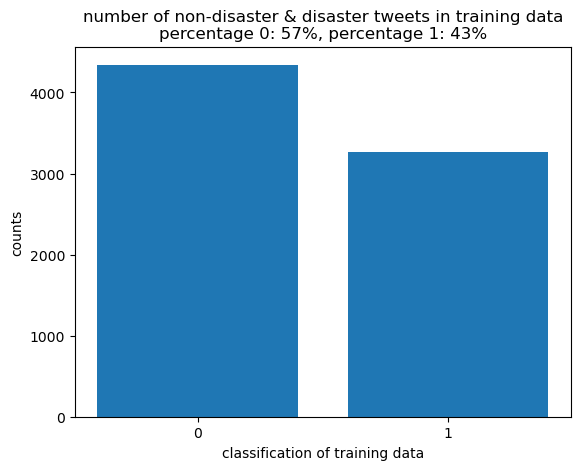

In [257]:
plt.bar(counts.index,counts.values)
plt.xticks([0,1])
plt.xlabel("classification of training data")
plt.ylabel("counts")
plt.title("number of non-disaster & disaster tweets in training data" +"\n" + \
            "percentage 0: {:.0f}%, percentage 1: {:.0f}%"\
            .format(100*counts[0]/sum(counts),100*counts[1]/sum(counts)))

#print(counts[0]/sum(counts))
#plt.bar(,train["target"].value_counts())

Here, we see that non-disaster tweets make up about 57% of the data, with disaster tweets making up the remaining 43%.If we assume that the test data was randomly sampled from the same dataset, we can assume that it shares a similar distribution. Based on that assumption, a naive model that simply chooses 0 (the rounded average of the test data) for every text, would probably return around 57% for it's accuracy score. I had some spare submissions and was actually able to verify this.

With that all being said, our score to beat is 57%. Next is looking at tweets' hyperlinks:

### __URL Normalization__

Below is a helper function made to count the number of hyperlinks within a string

In [258]:
def count_hyper(text):
    return text.count("http")

Below the number of hyperlinks are counted per string, and a visualization for the prevalence of hyperlink count based on the type of tweet is shown.

Text(0, 0.5, 'counts')

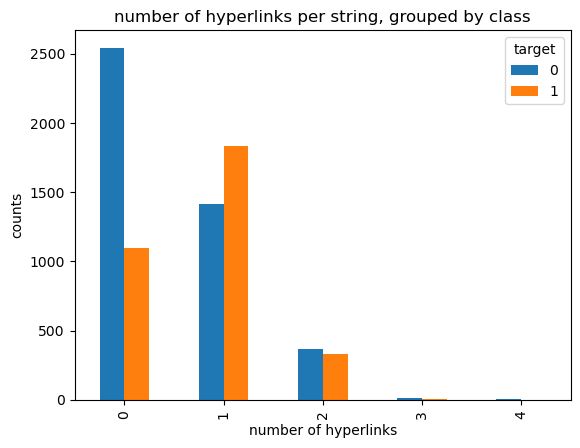

In [259]:
#count hyperlinks
train["num_hyperlinks"] = train["text"].apply(count_hyper)
#groupby num_hyperlinks and target, take the size and unstack so it can be used with the bar plot
groupedby = train.groupby(["num_hyperlinks","target"]).size().unstack()
groupedby.plot.bar()
plt.title("number of hyperlinks per string, grouped by class")
plt.xlabel("number of hyperlinks")
plt.ylabel("counts")

Interestingly enough, the presence of hyperlinks does seem to be an important, distinguishing characteristic for disaster, and non-disaster tweets. That being said, the current URLs are not very usable by the model, as they contain a random string (Ex: http://t.co/zDtoyd8EbJ). What can be done with these is URL normalization, where each URL is replaced with a standard placeholder to represent the presence of a hyperlink. The below function does just that

In [260]:
def standardize_url(text,placeholder):

     std_text = re.sub(r'http\S+',placeholder,text)
    
     return std_text

Using "urlhttp" as the keyword, the training and test sets have their URLS standardized below

In [261]:
test["text"]

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [262]:
placeholder = "urlhttp"
train['text_fixedurl'] = train["text"].apply(lambda text : standardize_url(text,placeholder))
test['text_fixedurl'] = test["text"].apply(lambda text : standardize_url(text,placeholder))

Before the removal of stopwords, common punctuation ought to be removed, or else it could cause us to misrepresent frequencies during our stopword removal. The same must be done for character casing. However, referencing symbols @ and # must be left intact.

### __Special Character Filtering__

For all intents and purposes, I will not classify the # or @ symbols as special characters, because they serve a specific and unique purpose within the text as user-given labels, and doing so could disrupt the structure of the dataset. Before I remove the special characters, let's get a quick visualization of how prevelant they are within the data.

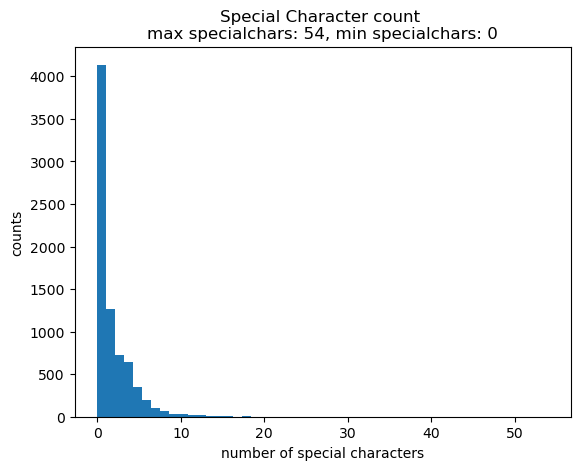

In [263]:
train["specialchar_count"] = train['text_fixedurl'].str.count(r'[!$%^&*(),.?":{}|<>]')
special = train["specialchar_count"]


plt.hist(train["specialchar_count"],bins = 50)
plt.title("Special Character count \n" +\
          "max specialchars: {}, min specialchars: {}".format(special.max(),special.min()))
plt.xlabel("number of special characters")
plt.ylabel("counts")
plt.show()

Although many tweets do not contain special characters, there are some which have up to 54. As such, they should be removed to avoid interfering with the tokenizer for stop word removal, as well as the RNN models.

In [264]:
def filter_characters(text):
    #Characters to keep, which includes alphanumeric, whitespace, @, #
    #The carat ^ negates whatever is in the set, so re.sub() can apply for everything other than the pattern
    to_keep = r'[^a-zA-Z0-9\s@#]'

    #Replace characters not in the pattern with an empty string, removing them
    filtered_text = re.sub(to_keep, '', text)
    
    return filtered_text

In [265]:
#filters characters
train["text_nospec"] = train["text_fixedurl"].apply(filter_characters)
test["text_nospec"] = test["text_fixedurl"].apply(filter_characters)

In [266]:
#converts to lowercase
train["text_nospec"] = train["text_nospec"].apply(lambda text:text.lower())
test["text_nospec"] = test["text_nospec"].apply(lambda text:text.lower())

### __Stopword Removal__

I am using a premade set of stopwords provided by the natural language toolkit, it is fairly comprehensive and contains 179 stopwords. it also needs to be processed to remove punctuation for full compatibility with our data.

In [267]:
stop_words = set(stopwords.words("english"))
# removal of punctuation
stop_words_nopun = [filter_characters(word) for word in stop_words]

#number of them
print(len(stop_words_nopun))
#first 10 stopwords
print(stop_words_nopun[:10])

179
['all', 'hasnt', 'was', 'because', 'mightn', 'is', 'couldn', 'out', 'youll', 'a']


In [268]:
#helper function to remove stopword
def drop_stopwords(text,stop_words):
    #tokenizes text entry as sequence of seperate words, rather than a single string
    text_tokenized = word_tokenize(text)
    #rebuilds text entry sequence based on non-stop words
    kept_sequence = set([word for word in text_tokenized if word not in stop_words])
    #rejoins the sequence via whitespace to build string
    new_string = " ".join(kept_sequence)
    return new_string

In [269]:
# applies the function across the dataframe
train["text_nostop"] = train["text_nospec"].apply(lambda text: drop_stopwords(text, stop_words_nopun))
test["text_nostop"] = test["text_nospec"].apply(lambda text: drop_stopwords(text, stop_words_nopun))

#the NLTK tokenizer adds whitespace to special characters, so this just amends that
train["text_nostop"] = train["text_nostop"].apply(lambda text:text.replace("# ","#"))
test["text_nostop"] = test["text_nostop"].apply(lambda text:text.replace("# ","#"))

train["text_nostop"] = train["text_nostop"].apply(lambda text:text.replace("@ ","@"))
test["text_nostop"] = test["text_nostop"].apply(lambda text:text.replace("@ ","@"))

### __Feature injection__

Now, I'll implement some feature injection by adding the tweet's keyword (when applicable) back into the text in the form of a hashtag at the end of the tweet.

In [270]:
#Helper function to remove the spacer from the keywords
def remove_spacer(text):
    spacer = '%20'
    cleaned_text = re.sub(spacer, '', text)
    if len(cleaned_text) > 0: #makes sure it doesn't add it to an empty string
        cleaned_text = "#" + cleaned_text
    return cleaned_text

Preprocess keywords to remove spacer, and fill NA values with empty string

In [271]:
#when keywords are not found, nan is present, this just makes it so they can add easier later
train = train.fillna('')
test = test.fillna('')

# removes spacers on two-word "keywords"
train["keyword"] = train["keyword"].apply(remove_spacer)
test["keyword"] = test["keyword"].apply(remove_spacer)

Here are a few examples of the newly composed hashtags

In [272]:
train["keyword"].unique()[:10]

array(['', '#ablaze', '#accident', '#aftershock', '#airplaneaccident',
       '#ambulance', '#annihilated', '#annihilation', '#apocalypse',
       '#armageddon'], dtype=object)

Finally, add add the newly made hashtags to the end of their corresponding text

In [273]:
train["text_final"] =  train["text_nostop"] + " "+ train["keyword"] 
test["text_final"] = test["text_nostop"] + " "+   test["keyword"] 

With the text now fully processed, let's have a quick look at how it changes as the steps go on

In [274]:
textdf = pd.DataFrame({})
for key in train.keys():
    if "text" in key:
        textdf[key] = train[key]
textdf.head()

,text,text_fixedurl,text_nospec,text_nostop,text_final
0,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...,allah reason #deeds us may earthquake forgive,allah reason #deeds us may earthquake forgive
1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,near canada fire la sask ronge forest,near canada fire la sask ronge forest
2,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,place officers asked evacuation expected resid...,place officers asked evacuation expected resid...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",13000 people receive #wildfires evacuation ord...,wildfires #evacuation people orders receive ca...,wildfires #evacuation people orders receive ca...
4,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...,pours wildfires #ruby sent alaska smoke photo ...,pours wildfires #ruby sent alaska smoke photo ...


## __RNN Model Architecture__

In [275]:
# set random seed for training
tf.random.set_seed(42)

Below is the general architecture that I chose for this problem. First let's go over the embedding.

I chose an input dimension of 5000, and an output dimension of 500, which allowed most of the models enough wiggle room to not overfit immediately. Uniform embedding was chosen as it's an effective simple starting point in the earlier training. It has a larger spread across parameter space, which could explain why it seemed to outperform the other options.
 seemed to generally outperform the others, which can likely be attributed to it's large spread across parameter space, which could allow the model to 

The below code takes in a list "architecture", and creates Bidirectional LSTM layers with however many units are specified within that particular element within the list. It makes explaining separate models separately easier, when the architectural things varying between them are their LSTM layers. I chose Bidirectional Long Short-Term Memory (LSTM) as my model due to it's generally higher flexibility and track record of high performance. Making the layers Bidirectional over single directional allows for improved context within the string, which can be very important for NLP, where a particular word's meaning will change depending on what is before and after it (context).

 I was originally concerned about the computational cost of it, but once I managed to properly set up my GPU with tensorflow it was no longer an issue. 

 These are the "architectures" I will cover in this section (each list element e represents an LSTM layer with units=e):

-Model 1: Funneling [64,8]

-Model 2: Inverted Funneling [8,64]

-Model 3: Pyramid [8,64,8]

-Model 4: High-Feature [128,128,128]

-Model 5: Low Feature [4]

In [301]:
def make_RNN_model(train,labels,architecture,learning_rate,max_sequence_length,epochs):
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Embedding(input_dim=5000,output_dim=500,\
        input_length=max_sequence_length,embeddings_initializer="uniform"))
        
    for i,arc in enumerate(architecture):

        if i+1 == len(architecture):
            seq_ret = False
        
        else:
            seq_ret = True

        model.add(Bidirectional(LSTM(units = arc, return_sequences=seq_ret)))



    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train, labels, epochs=epochs, batch_size=30, validation_split=0.2)
    return history

In [302]:
#convert data into format usable by the model
tweets_train = train["text_final"].tolist()
tweets_test = test["text_final"].tolist()
labels = np.array(train["target"].tolist())

Here is the tokenizer needed to process text for feeding into model

In [303]:
# Tokenize text, match input dimensions
tokenizer = Tokenizer(num_words = 5000)  # Adjust num_words based on vocabulary size
#fits tokenizer to training data
tokenizer.fit_on_texts(tweets_train)

#applies it to test and training data
train_sequences = tokenizer.texts_to_sequences(tweets_train)
test_sequences = tokenizer.texts_to_sequences(tweets_test)

# find max tweet length for padding
max_sequence_length = max(train["text_final"].apply(len))

#pads tweet strings to have equal length for model training 
train_padded = pad_sequences(train_sequences,maxlen = max_sequence_length)
test_padded = pad_sequences(test_sequences,maxlen = max_sequence_length)

### Model 1: Funneling [64,8]

This model has a "Funneling" type of architecture, where the number of units are lowered between layers, forcing to the model focus on the more important features found by the earlier, feature-rich layers. 

Although I wanted my different funneling-type schemes to have a more gradual feature reduction, X8 unit reduction seemed to be the cleanest tradeoff in terms of training time, performance, and lack of overfitting.

In [304]:
#model 1 architecture
model1_arc = [64,8]
epochs = 10
#solid learning rate for architecture
learning_rate = 0.00005
#make the model
model1 = make_RNN_model(train_padded,labels,model1_arc,learning_rate,max_sequence_length,epochs)

Epoch 1/10
203/203 [==============================] - 10s 36ms/step - loss: 0.6730 - accuracy: 0.5793 - val_loss: 0.6756 - val_accuracy: 0.5345
Epoch 2/10
203/203 [==============================] - 7s 33ms/step - loss: 0.6312 - accuracy: 0.6524 - val_loss: 0.6009 - val_accuracy: 0.7255
Epoch 3/10
203/203 [==============================] - 7s 32ms/step - loss: 0.4801 - accuracy: 0.8066 - val_loss: 0.5020 - val_accuracy: 0.7800
Epoch 4/10
203/203 [==============================] - 7s 33ms/step - loss: 0.3984 - accuracy: 0.8502 - val_loss: 0.5103 - val_accuracy: 0.7754
Epoch 5/10
203/203 [==============================] - 7s 33ms/step - loss: 0.3536 - accuracy: 0.8718 - val_loss: 0.5035 - val_accuracy: 0.7741
Epoch 6/10
203/203 [==============================] - 7s 33ms/step - loss: 0.3268 - accuracy: 0.8796 - val_loss: 0.5053 - val_accuracy: 0.7840
Epoch 7/10
203/203 [==============================] - 7s 33ms/step - loss: 0.3089 - accuracy: 0.8941 - val_loss: 0.5341 - val_accuracy: 0.770

### Model 2: Inverted Funneling [8,64]

This model has a "Inverted Funneling" type of architecture, where the number of units are raised between layers. The initial layer has relatively few features, acting as a kind of compression for the model, which forces the rest of the model to work with only on the more obvious, prominent features throughout the data, rather than the more nuanced, complex ones found with regular funnelling architectures.

In [305]:
#model 2 architecture
model2_arc = [8,64]
epochs = 10
#solid learning rate for architecture
learning_rate = 0.00005
#make the model
model2 = make_RNN_model(train_padded,labels,model2_arc,learning_rate,max_sequence_length,epochs)

Epoch 1/10
203/203 [==============================] - 10s 35ms/step - loss: 0.6794 - accuracy: 0.5793 - val_loss: 0.6860 - val_accuracy: 0.5345
Epoch 2/10
203/203 [==============================] - 6s 31ms/step - loss: 0.6527 - accuracy: 0.5924 - val_loss: 0.6366 - val_accuracy: 0.7157
Epoch 3/10
203/203 [==============================] - 6s 31ms/step - loss: 0.5273 - accuracy: 0.7683 - val_loss: 0.5012 - val_accuracy: 0.7840
Epoch 4/10
203/203 [==============================] - 6s 31ms/step - loss: 0.3911 - accuracy: 0.8407 - val_loss: 0.4689 - val_accuracy: 0.7833
Epoch 5/10
203/203 [==============================] - 6s 31ms/step - loss: 0.3394 - accuracy: 0.8706 - val_loss: 0.4553 - val_accuracy: 0.7991
Epoch 6/10
203/203 [==============================] - 6s 31ms/step - loss: 0.3005 - accuracy: 0.8933 - val_loss: 0.4846 - val_accuracy: 0.7820
Epoch 7/10
203/203 [==============================] - 6s 31ms/step - loss: 0.2727 - accuracy: 0.9064 - val_loss: 0.5147 - val_accuracy: 0.789

### Model 3: "Pyramid" [8,64,8]

This "Pyramid" architecture is a combination of inverted funneling followed by funneling. It behaves much like inverted funneling, except that the final, low feature layer acts a "summarization" for the findings of the feature-rich middle layer, which could potentially make it perform more consistently than just the inverted funnel schema.

In [306]:
#model 3 architecture
model3_arc = [8,64,8]
epochs = 10
#solid learning rate for architecture
learning_rate = 0.00005
#make the model
model3 = make_RNN_model(train_padded,labels,model3_arc,learning_rate,max_sequence_length,epochs)

Epoch 1/10
203/203 [==============================] - 15s 50ms/step - loss: 0.6764 - accuracy: 0.5770 - val_loss: 0.6791 - val_accuracy: 0.5345
Epoch 2/10
203/203 [==============================] - 9s 46ms/step - loss: 0.6256 - accuracy: 0.6525 - val_loss: 0.5853 - val_accuracy: 0.7492
Epoch 3/10
203/203 [==============================] - 9s 45ms/step - loss: 0.4781 - accuracy: 0.8153 - val_loss: 0.5054 - val_accuracy: 0.7800
Epoch 4/10
203/203 [==============================] - 9s 46ms/step - loss: 0.4056 - accuracy: 0.8545 - val_loss: 0.4864 - val_accuracy: 0.7853
Epoch 5/10
203/203 [==============================] - 9s 45ms/step - loss: 0.3563 - accuracy: 0.8796 - val_loss: 0.4841 - val_accuracy: 0.7873
Epoch 6/10
203/203 [==============================] - 9s 45ms/step - loss: 0.3181 - accuracy: 0.8998 - val_loss: 0.5084 - val_accuracy: 0.7702
Epoch 7/10
203/203 [==============================] - 9s 45ms/step - loss: 0.2920 - accuracy: 0.9131 - val_loss: 0.5422 - val_accuracy: 0.767

### Model 4: High-Feature [128,128,128]

This is just a pure, feature rich RNN with 128 units for each of its three layers. Out of these models, this one should be able to capture more complex patterns than the others, given it's relatively high feature representation. With this however, comes a greater chance to overfit as well.

It converges faster than the other RNNS, so a lower learning rate had to be implemented.

In [307]:
#model 4 architecture
model4_arc = [128,128,128]
epochs = 10
#solid learning rate for architecture
learning_rate = 0.000025
#make the model
model4 = make_RNN_model(train_padded,labels,model4_arc,learning_rate,max_sequence_length,epochs)

Epoch 1/10
203/203 [==============================] - 15s 57ms/step - loss: 0.6736 - accuracy: 0.5768 - val_loss: 0.6721 - val_accuracy: 0.5345
Epoch 2/10
203/203 [==============================] - 10s 51ms/step - loss: 0.6308 - accuracy: 0.6442 - val_loss: 0.5945 - val_accuracy: 0.6861
Epoch 3/10
203/203 [==============================] - 10s 51ms/step - loss: 0.4719 - accuracy: 0.7880 - val_loss: 0.4975 - val_accuracy: 0.7597
Epoch 4/10
203/203 [==============================] - 10s 51ms/step - loss: 0.3799 - accuracy: 0.8420 - val_loss: 0.4993 - val_accuracy: 0.7564
Epoch 5/10
203/203 [==============================] - 10s 52ms/step - loss: 0.3414 - accuracy: 0.8637 - val_loss: 0.4829 - val_accuracy: 0.7735
Epoch 6/10
203/203 [==============================] - 10s 52ms/step - loss: 0.3072 - accuracy: 0.8839 - val_loss: 0.5145 - val_accuracy: 0.7610
Epoch 7/10
203/203 [==============================] - 10s 51ms/step - loss: 0.2832 - accuracy: 0.8951 - val_loss: 0.5321 - val_accuracy:

### Model 5: Low-Feature [4]

This is a very low-feature RNN that features only a single layer with 4 units. High performance of this model could imply simplicity in the dataset.

In [308]:
#model 4 architecture
model5_arc = [4]
epochs = 10
#solid learning rate for architecture
learning_rate = 0.0001 #higher learning rate needed
#make the model
model5 = make_RNN_model(train_padded,labels,model5_arc,learning_rate,max_sequence_length,epochs)


Epoch 1/10
203/203 [==============================] - 5s 18ms/step - loss: 0.6826 - accuracy: 0.5747 - val_loss: 0.6870 - val_accuracy: 0.5345
Epoch 2/10
203/203 [==============================] - 3s 17ms/step - loss: 0.6623 - accuracy: 0.5793 - val_loss: 0.6748 - val_accuracy: 0.5345
Epoch 3/10
203/203 [==============================] - 3s 17ms/step - loss: 0.6295 - accuracy: 0.6099 - val_loss: 0.6499 - val_accuracy: 0.5732
Epoch 4/10
203/203 [==============================] - 3s 17ms/step - loss: 0.5869 - accuracy: 0.7619 - val_loss: 0.6248 - val_accuracy: 0.7078
Epoch 5/10
203/203 [==============================] - 3s 17ms/step - loss: 0.5431 - accuracy: 0.8263 - val_loss: 0.6038 - val_accuracy: 0.7485
Epoch 6/10
203/203 [==============================] - 3s 17ms/step - loss: 0.4992 - accuracy: 0.8509 - val_loss: 0.5869 - val_accuracy: 0.7774
Epoch 7/10
203/203 [==============================] - 3s 17ms/step - loss: 0.4568 - accuracy: 0.8693 - val_loss: 0.5736 - val_accuracy: 0.7846

## Results and Analysis

In [309]:
# create list of models made thus far, and their names
histories = [globals()["model"+str(i)] for i in range(1,6)]
model_names = ["Fun","InvFun","Pyrm","Hi-Fe","Lo-Fe"]

Below is a plot of each model's training accuracies by epoch. Thanks to the properly chosen learning rates, they all converge, but not too quickly. There seems to be an interesting trend for 4/5 of the models where their validation accuracy outperforms their training accuracy for the first few epochs. This could just be an example of these architectures capable of generalizing well given _very_ little chance to overfit. 

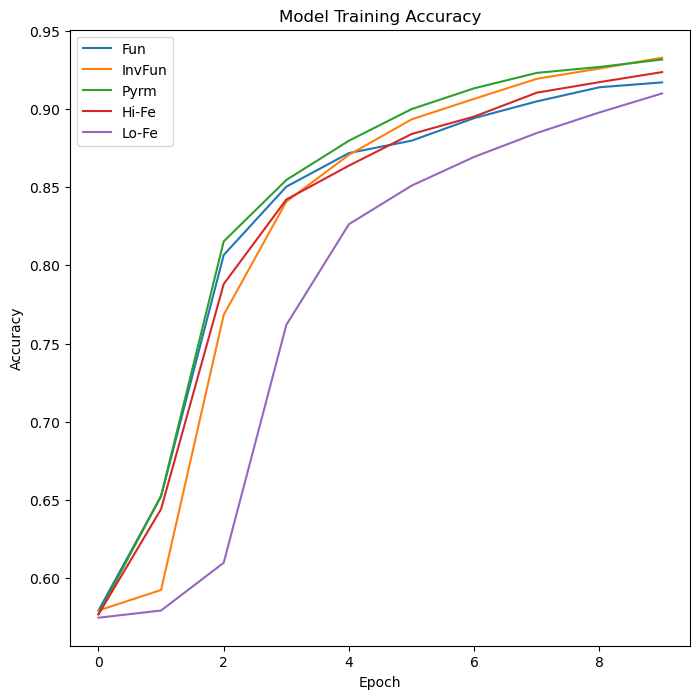

In [310]:
plt.figure(figsize = (8,8))
plt.title("Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
for history in histories:
    plt.plot(history.history["accuracy"])

plt.legend(model_names)

Below are plots of the model validation accuracies per epoch. Each model actually performs surprisingly well, even the incredibly simple single-layer 4-unit RNN model.

Within this range of epochs, each model's validation accuracy grows, peaks, and declines once they begin to overfit.

In the plot we can see that the inverted funnel architecture was able to achieve the highest validation accuracy out of all models, followed by Pyramid, low-feature, funnel, and lastly high-feature.

The high-feature model performed the worst out of all of them, having both the lowest high and lowest low over this range of epochs.

Despite all of that being said, all models at their best had fairly similar performance, and all have peaks within a few percent of one another.

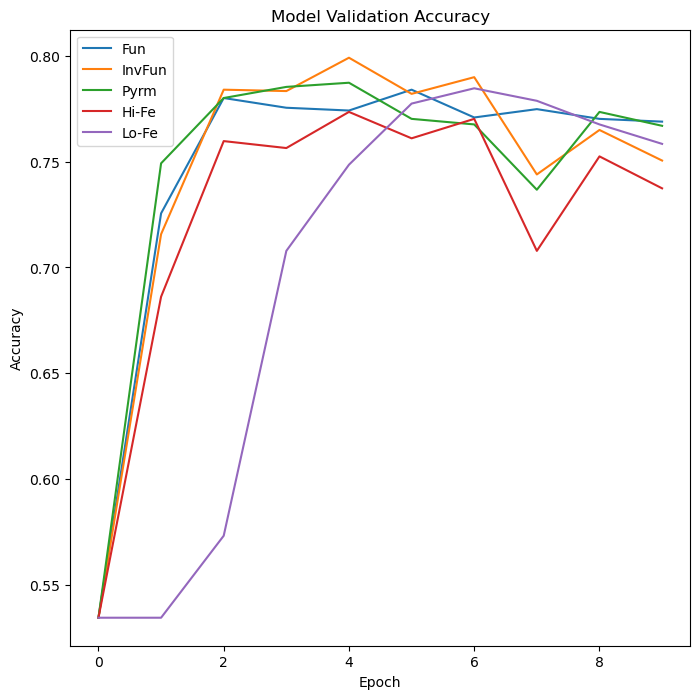

In [313]:
plt.figure(figsize = (8,8))
plt.title("Model Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
for history in histories:
    plt.plot(history.history["val_accuracy"])

plt.legend(model_names)

Compiled validation accuracy results into table

In [322]:
epochs = np.arange(1,10,1)
va_acc = []
for history in histories:
    va_acc.append(history.history["val_accuracy"])

table = pd.DataFrame({},columns = epochs)
table = table.append(va_acc)
table["model name"] = model_names

C:\Users\Angel\AppData\Local\Temp\ipykernel_32648\2834007669.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(va_acc)


Below is a table summarizing the validation accuracies for the 5 models explored in this project, over 10 epochs (it show 10 as 0 for some reason).

The best validation accuracy achieved proved to be 79.9% for epoch 4 of the Inverted Funnel Architecture, which is solid. This result handily beats the naive "rounded average" accuracy mentioned earlier, which would be around 57%.

In [323]:
table

,1,2,3,4,5,6,7,8,9,0,model name
0,0.725542,0.780039,0.775443,0.774130,0.783979,0.770847,0.774787,0.770190,0.768877,0.534471,Fun
1,0.715693,0.783979,0.783322,0.799081,0.782009,0.789888,0.743926,0.764938,0.750492,0.534471,InvFun
2,0.749179,0.780039,0.785292,0.787262,0.770190,0.767564,0.736704,0.773473,0.766907,0.534471,Pyrm
3,0.686146,0.759685,0.756402,0.773473,0.760998,0.770190,0.707814,0.752462,0.737360,0.534471,Hi-Fe
4,0.534471,0.573211,0.707814,0.748523,0.777413,0.784636,0.778726,0.767564,0.758372,0.534471,Lo-Fe


Generally, each model was able to peform quite well with the given dataset. However, the ones that have an initially limited capacity to recognize and represent complex patterns in the given data were the ones that actually performed the best out of them. Even the single layer, 4-unit RNN was able to exhibit superior performance to the two RNNs with the highest, and second highest feature respresentation within their first layers. 

These results seem to suggest that low initial feature architectures are better suited to this particular dataset, as the two relatively high-feature architectures starting at 64 and 128 performed had the second worst, and worst performance respectively. However, the lowest intial feature model did not outperform the other two, the reason being inconclusive without testing further architectures with starting units of 4.

The greatest challenge that I had when working with this dataset was getting any of my models to stop from overfitting. I was originally trying architectures like [128,256,512] with learning rate of 0.001, but the validation accuracy would immedately peak at the first epoch. It was only when I scaled the feature representation of the models way back, and reduced the training rate by at least a full order of magnitude, did I see proper model convergence, as well as improved performance!

## Conclusion

In the end, I was happy with my model's performance for this competition, but I am disappointed that I was not able to exceed 80% validation accuracy. My kaggle score ended up being 79.3%, which agrees well with the validation data, which I am also content with.

Ultimately, the performance of my models may suggest oversimplicity within the dataset, for such low-feature models to outperform higher feature models. This could make sense given the depth to which the data was cleaned. Although the cleaning was performed with the express purpose of making the data more "understandable" for the models, it may have made the data _too_ easy to understand. It could be that some things of importance may have been lost with all of that cleaning, and that the models as a whole, especially the higher-feature ones would perform better with a less-modified dataset.

Improvements I could try in the future would be to repeat the tests performed here, but for each variant of text data made throughout the cleaning process. Doing so may help highlight when when cleaning helps the model, and when it is getting in the way, removing things that the model could have leveraged to improve.

## Extra

Here's what I used to make my kaggle submission

In [324]:
#model 2 architecture
model_kag_arc = [8,64]
epochs = 4
#chosen learning rate for architecture
learning_rate = 0.00005
model_kag = make_RNN_model(train_padded,labels,model_kag_arc,learning_rate,max_sequence_length,epochs)

Epoch 1/4
203/203 [==============================] - 10s 35ms/step - loss: 0.6775 - accuracy: 0.5790 - val_loss: 0.6833 - val_accuracy: 0.5345
Epoch 2/4
203/203 [==============================] - 6s 31ms/step - loss: 0.6497 - accuracy: 0.5938 - val_loss: 0.6313 - val_accuracy: 0.6829
Epoch 3/4
203/203 [==============================] - 6s 31ms/step - loss: 0.5143 - accuracy: 0.7806 - val_loss: 0.4865 - val_accuracy: 0.7807
Epoch 4/4
203/203 [==============================] - 6s 31ms/step - loss: 0.3831 - accuracy: 0.8455 - val_loss: 0.4650 - val_accuracy: 0.7761


In [325]:
predictions = model_test.predict(test_padded)
predicted_labels = np.round(predictions)

out_df = pd.DataFrame({"id" : test["id"]})
out_df["target"] = predicted_labels
out_df.to_csv(data_dir +"test_submission.csv",index = False)

102/102 [==============================] - 2s 14ms/step
